# Import  
파이썬에서 다른 모듈이나 패키지에서 함수, 클래스 등을 가져옵니다.

In [1]:
!pip install koreanize-matplotlib
import koreanize_matplotlib


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: C:\Users\HOME\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler,StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

#### 시드(seed) 고정  
매번 고정된 결과를 얻기 위해서 사용합니다.  
시드를 고정하지 않는다면 같은 코드라도 매번 다른 결과가 나올 수 있습니다.

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

#### 데이터 읽어오기 및 데이터 확인

In [4]:
# pd.read_csv() 함수를 사용해서 데이터를 읽어오는 코드입니다.
train = pd.read_csv('C:/Users/HOME/Downloads/범죄분류데이터/train.csv')

# 데이터를 확인하기 위해 head() 함수를 사용합니다.
train.head()

,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET
0,TRAIN_00000,9,화요일,10,137,8.0,2.611124,0.000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2
1,TRAIN_00001,11,화요일,6,438,13.0,3.209093,0.000,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0
2,TRAIN_00002,8,일요일,6,1729,47.0,1.619597,0.000,0.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,인도,1
3,TRAIN_00003,5,월요일,6,2337,53.0,1.921615,11.375,0.0,0.0,225.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,주거지,1
4,TRAIN_00004,9,일요일,11,1439,41.0,1.789721,0.000,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,주유소,2


#### 독립변수(x_train), 종속변수(y_train)로 분리하기  


In [5]:
x_train = train.drop(['ID', 'TARGET'], axis = 1)
y_train = train['TARGET']


#### train , validation data 나누기

In [6]:
X_tr, X_val, Y_tr, Y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

#### 라벨인코딩(Label Encoding)

In [7]:

ordinal_features = ['요일', '범죄발생지']

for feature in ordinal_features:
    le = LabelEncoder()

    # Fit and transform on the training data
    le = le.fit(X_tr[feature])
    X_tr[feature] = le.transform(X_tr[feature])

    # Transform the test data (Note: Only transform, do not fit again to avoid data leakage)
    X_val[feature] = le.transform(X_val[feature])



### Voting

In [8]:
xgb_classifier = XGBClassifier()
catboost_classifier = CatBoostClassifier(random_state=42, iterations=200, learning_rate=0.1, verbose=100)
gb_classifier = GradientBoostingClassifier()

# VotingClassifier 정의
voting_classifier = VotingClassifier(
    estimators=[('xgb', xgb_classifier), ('catboost', catboost_classifier), ('gb', gb_classifier)],
    voting='soft'  # 여러 모델의 예측값을 확률로 변환한 후 평균을 구함
)

# VotingClassifier 학습
voting_classifier.fit(X_tr, Y_tr)

# VotingClassifier 예측
y_pred = voting_classifier.predict(X_val)

0:	learn: 1.0789886	total: 169ms	remaining: 33.7s
100:	learn: 0.9606761	total: 1.02s	remaining: 1s
199:	learn: 0.9454792	total: 1.78s	remaining: 0us


#### 예측

정확도 : 0.5541
정말도 : 0.5525
Recall: 0.5541
F1 Score: 0.5435
Confusion Matrix:
[[8059 1212 1648]
 [3042 3315 1285]
 [3096 1007 2658]]


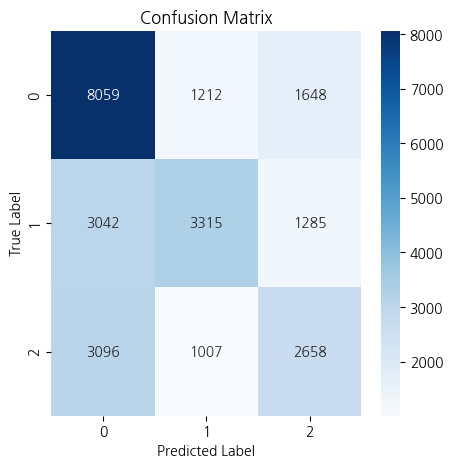

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc=accuracy_score(Y_val,y_pred)
print(f'정확도 : {acc:.4f}')

# 정밀도 (precision)
precision=precision_score(Y_val,y_pred, average='weighted')
print(f'정말도 : {precision:.4f}')

recall = recall_score(Y_val, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')

# F1 점수 (F1 Score)
f1 = f1_score(Y_val, y_pred, average='weighted')
print(f'F1 Score: {f1:.4f}')

# 혼동 행렬 (Confusion Matrix)
conf_matrix = confusion_matrix(Y_val, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Sampling

##### 오버샘플링

In [10]:
ros=RandomUnderSampler(random_state=42)
x_tr_over,y_tr_over=ros.fit_resample(X_tr,Y_tr)


In [11]:
xgb_classifier = XGBClassifier()
catboost_classifier = CatBoostClassifier(random_state=42, iterations=200, learning_rate=0.1, verbose=100)
gb_classifier = GradientBoostingClassifier()

# VotingClassifier 정의
voting_classifier = VotingClassifier(
    estimators=[('xgb', xgb_classifier), ('catboost', catboost_classifier), ('gb', gb_classifier)],
    voting='soft'  # 여러 모델의 예측값을 확률로 변환한 후 평균을 구함
)

# VotingClassifier 학습
voting_classifier.fit(x_tr_over,y_tr_over)

# VotingClassifier 예측
y_pred = voting_classifier.predict(X_val)

0:	learn: 1.0829128	total: 10.5ms	remaining: 2.09s
100:	learn: 0.9774182	total: 722ms	remaining: 708ms
199:	learn: 0.9594894	total: 1.35s	remaining: 0us


정확도 : 0.5491
정말도 : 0.5475
Recall: 0.5491
F1 Score: 0.5469
Confusion Matrix:
[[7128 1759 2032]
 [2295 3755 1592]
 [2615 1124 3022]]


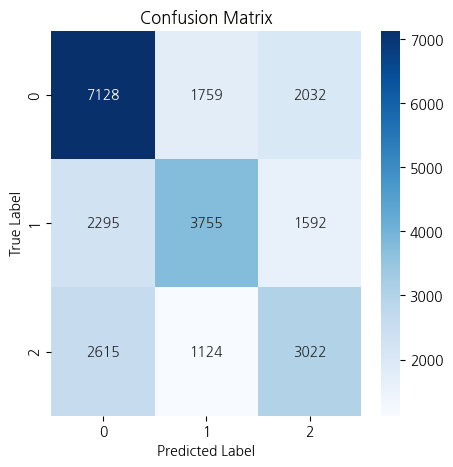

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc=accuracy_score(Y_val,y_pred)
print(f'정확도 : {acc:.4f}')

# 정밀도 (precision)
precision=precision_score(Y_val,y_pred, average='weighted')
print(f'정말도 : {precision:.4f}')

recall = recall_score(Y_val, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')

# F1 점수 (F1 Score)
f1 = f1_score(Y_val, y_pred, average='weighted')
print(f'F1 Score: {f1:.4f}')

# 혼동 행렬 (Confusion Matrix)
conf_matrix = confusion_matrix(Y_val, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [15]:
# 샘플링 과정이 없던 모델보다 성능이 좋은 것 확인
# 가장 분류가 안되었던 class 3이 이전 모델보다 훨씬 많이 분류되었음

##### SMOTE

In [13]:
smote=SMOTE(random_state=42)
x_tr_smote,y_tr_smote=smote.fit_resample(X_tr,Y_tr)

In [14]:
xgb_classifier = XGBClassifier()
catboost_classifier = CatBoostClassifier(random_state=42, iterations=200, learning_rate=0.1, verbose=100)
gb_classifier = GradientBoostingClassifier()

# VotingClassifier 정의
voting_classifier = VotingClassifier(
    estimators=[('xgb', xgb_classifier), ('catboost', catboost_classifier), ('gb', gb_classifier)],
    voting='soft'  # 여러 모델의 예측값을 확률로 변환한 후 평균을 구함
)

# VotingClassifier 학습
voting_classifier.fit(x_tr_smote,y_tr_smote)

# VotingClassifier 예측
y_pred = voting_classifier.predict(X_val)

0:	learn: 1.0821486	total: 26.8ms	remaining: 5.34s
100:	learn: 0.9541266	total: 1.13s	remaining: 1.11s
199:	learn: 0.9308170	total: 2.22s	remaining: 0us


정확도 : 0.5499
정말도 : 0.5474
Recall: 0.5499
F1 Score: 0.5445
Confusion Matrix:
[[7530 1479 1910]
 [2628 3533 1481]
 [2816 1083 2862]]


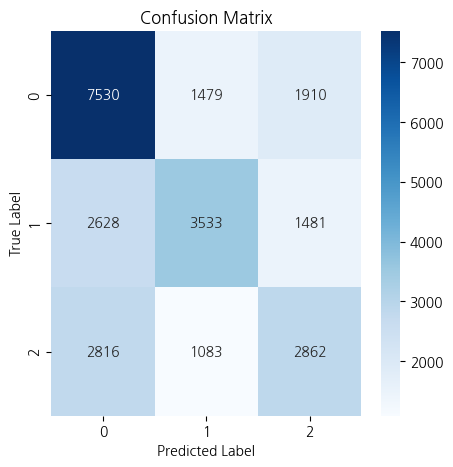

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc=accuracy_score(Y_val,y_pred)
print(f'정확도 : {acc:.4f}')

# 정밀도 (precision)
precision=precision_score(Y_val,y_pred, average='weighted')
print(f'정말도 : {precision:.4f}')

recall = recall_score(Y_val, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')

# F1 점수 (F1 Score)
f1 = f1_score(Y_val, y_pred, average='weighted')
print(f'F1 Score: {f1:.4f}')

# 혼동 행렬 (Confusion Matrix)
conf_matrix = confusion_matrix(Y_val, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

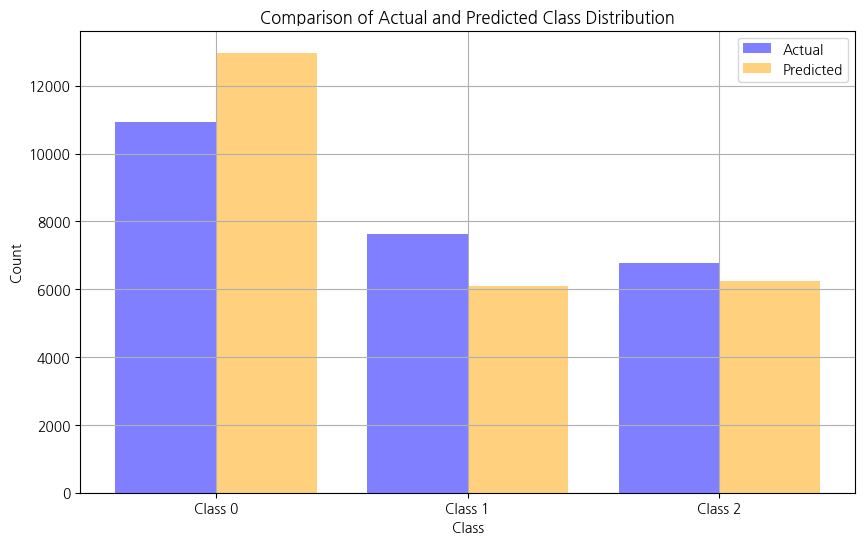

In [19]:

classes = ['Class 0', 'Class 1', 'Class 2']
class_labels = np.unique(Y_val)

# 실제값과 예측값에 대한 카운트 계산
actual_counts = np.bincount(Y_val)
predicted_counts = np.bincount(y_pred)

# 클래스별 실제값과 예측값의 비교를 시각화
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(classes)) - 0.2, actual_counts, width=0.4, align='center', label='Actual', color='blue', alpha=0.5)
plt.bar(np.arange(len(classes)) + 0.2, predicted_counts, width=0.4, align='center', label='Predicted', color='orange', alpha=0.5)
plt.xticks(np.arange(len(classes)), classes)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Comparison of Actual and Predicted Class Distribution')
plt.legend()
plt.grid(True)
plt.show()
